# Analog bit project walkthrough

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
try:
    from tueplots import bundles
    plt.rcParams.update(bundles.neurips2022())
except ModuleNotFoundError:
    pass
%load_ext autoreload
%autoreload 2

2023-05-17 11:08:21.866213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 11:08:22.891376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## How to generate the data

Several ways to create data, only one generator is implemented, the ```flags``` dataset

In [2]:
# imports
from utils.data_gen import get_data_gen

In [3]:
generate_train_data = get_data_gen('flags', (3,8), 30000, rgb=True)
generate_test_data = get_data_gen('flags', (3,8), 20, rgb=True)

In [4]:
train_data = generate_train_data()
test_data = generate_test_data()

In [5]:
train_data.shape

(30000, 3, 8, 3)

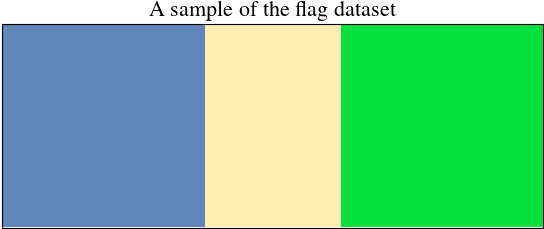

In [6]:
from utils.display import show_flag
show_flag(train_data[2])

## Fake predictor task

To test our model, we will create a false ground truth

In [7]:
# Fake ground truth
def invert_color(data : np.ndarray):
    """Invert the color of RGB channels"""
    return 255 - data
train_ground_truth = invert_color(train_data)
test_ground_truth = invert_color(test_data)

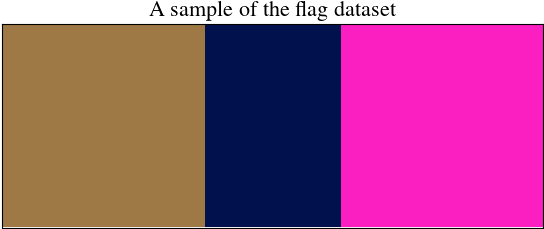

In [8]:
show_flag(train_ground_truth[2])

## Convert to bits

In [9]:
from utils.bit_encoding import rgb2bit, get_x_channels

b_type = 'uint8'
channels = get_x_channels(b_type)
kwargs = {'b_type': b_type, 'b_scale': 1.0, 'x_channels': channels}
train_data_bits = rgb2bit(images=train_data, **kwargs)
gt_train_data_bits = rgb2bit(images=train_ground_truth, **kwargs)
test_data_bits = rgb2bit(images=test_data, **kwargs)
gt_test_data_bits = rgb2bit(images=test_ground_truth, **kwargs)

2023-05-17 11:08:35.474958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 11:08:35.519019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 11:08:35.519353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
print("(Number of samples, height, width, analogbits) =", train_data_bits.shape)

(Number of samples, height, width, analogbits) = (30000, 3, 8, 24)



## Define noise and denoiser step

In [20]:
tf.debugging.set_log_device_placement(True)

In [21]:
from models.dummy_model import get_model
input_shape = train_data_bits.shape[1:]
model = get_model(input_shape=input_shape, model_name='dummy')

In [22]:
model(train_data_bits).shape

TensorShape([30000, 3, 8, 24])

In [26]:
train_dataset_bits = tf.data.Dataset.from_tensor_slices(train_data_bits)
gt_train_dataset_bits = tf.data.Dataset.from_tensor_slices(gt_train_data_bits)
test_dataset_bits = tf.data.Dataset.from_tensor_slices(test_data_bits)
gt_test_datasets_bits = tf.data.Dataset.from_tensor_slices(gt_test_data_bits)

In [27]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

In [30]:
features = next(iter(train_dataset_bits.batch(32)))
ground_truth = next(iter(gt_train_dataset_bits.batch(32)))
l = loss_fn(model(features), ground_truth)
print("Loss test: {}".format(l))

Loss test: 0.999622106552124


2023-05-17 11:13:41.187520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [30000,3,8,24]
	 [[{{node Placeholder/_0}}]]
2023-05-17 11:13:41.284935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [30000,3,8,24]
	 [[{{node Placeholder/_0}}]]


In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [32]:
training_dataset = tf.data.Dataset.zip((train_dataset_bits, gt_train_dataset_bits))

In [33]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn
)

In [34]:
model.fit(
    x=training_dataset.batch(512),
    epochs=10,
    verbose=1
)

Epoch 1/10
  3/118 [..............................] - ETA: 4s - loss: 0.9869

2023-05-17 11:14:01.116913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [30000,3,8,24]
	 [[{{node Placeholder/_2}}]]


118/118 [==============================] - 4s 36ms/step - loss: 0.7421
Epoch 2/10
118/118 [==============================] - 4s 38ms/step - loss: 0.6353
Epoch 3/10
118/118 [==============================] - 4s 37ms/step - loss: 0.6128
Epoch 4/10
118/118 [==============================] - 4s 37ms/step - loss: 0.6005
Epoch 5/10
118/118 [==============================] - 4s 36ms/step - loss: 0.5964
Epoch 6/10
118/118 [==============================] - 4s 36ms/step - loss: 0.5901
Epoch 7/10
118/118 [==============================] - 4s 38ms/step - loss: 0.5855
Epoch 8/10
118/118 [==============================] - 4s 37ms/step - loss: 0.5783
Epoch 9/10
118/118 [==============================] - 5s 38ms/step - loss: 0.5748
Epoch 10/10
118/118 [==============================] - 5s 38ms/step - loss: 0.5715


In [35]:
feature_test = model(features, training=False)

In [36]:
from utils.bit_encoding import bit2rgb
feature_test_int = bit2rgb(feature_test, b_type=b_type)
feature_int = bit2rgb(features, b_type=b_type)

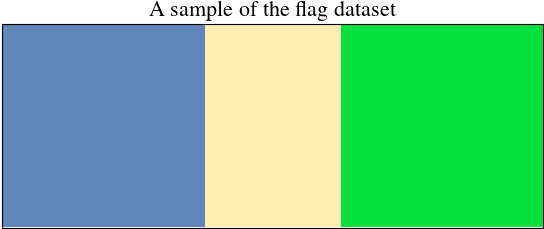

In [37]:
# Original data
show_flag(feature_int[2])

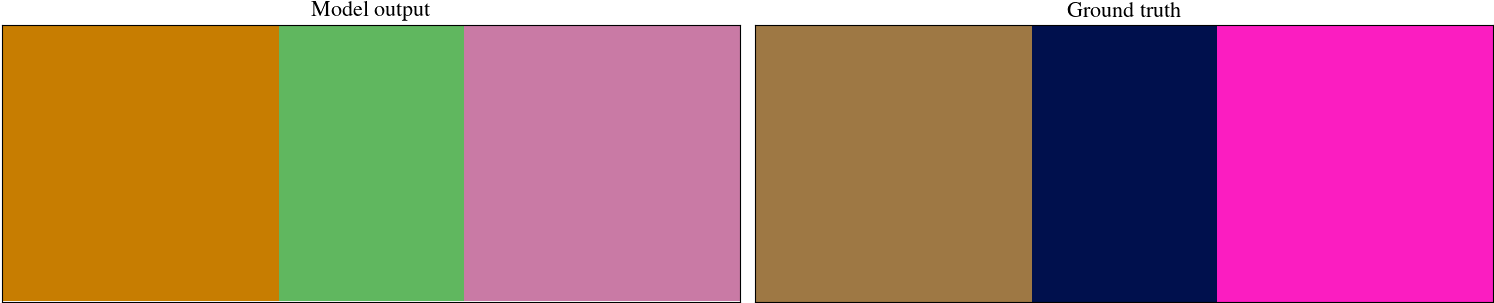

In [38]:
from matplotlib import ticker

fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].imshow(feature_test_int[2])
axs[0].set_title('Model output', fontsize=16)
axs[0].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[0].yaxis.set_major_locator(ticker.NullLocator())

axs[1].imshow(1.0 - feature_int[2])
axs[1].set_title('Ground truth', fontsize=16)
axs[1].xaxis.set_major_locator(ticker.NullLocator())
_ = axs[1].yaxis.set_major_locator(ticker.NullLocator())

## Now using diffusion

In [39]:
from utils.diffusion_utils import Scheduler
scheduler = Scheduler('cosine')

In [40]:
inputs_noised, noise, time_step, gamma = scheduler.add_noise(train_data_bits)

In [41]:
from models.analog_bits import Model

In [42]:
from argparse import Namespace
from dotwiz import DotWiz

config = {
    'dataset': {
        'image_size' : (3,8),
        'num_classes' : 1,
    },
    'model' : {
        'train_schedule' : 'cosine',
        'x0_clip' : 'auto',
        'b_scale' : 1.0,
        'm_kwargs' : {
            'model_name' : 'custom',
            'input_shape' : (3,8,24)
        },
        'b_type' : 'uint8',
        'self_cond' : 'x',
        'pred_type' : 'eps',
        'conditional' : 'none',
        'normalize_noisy_input' : False,
        'infer_schedule' : 'cosine',
        'td' : 0,
        'guidance' : 0,
        'archname' : 'transunet'
    }
}
config = DotWiz(config)

In [43]:
model_new = Model(config)

In [44]:
output = model_new(train_data, train_data)

2023-05-17 11:15:01.493435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-17 11:15:03.800853: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 11:15:03.801921: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 11:15:03.801968: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-17 11:15:03.803189: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 11:15:03.803296: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

## Train the model

In [45]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = model(inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [46]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [47]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tqdm import tqdm

train_loss_results = []

model = Model(config)

images_diffusion_dataset = tf.data.Dataset.from_tensor_slices(train_data)
dummy_labels = tf.data.Dataset.from_tensor_slices(tf.zeros_like(train_data))
train_diffusion_dataset = tf.data.Dataset.zip((images_diffusion_dataset, dummy_labels))
train_batch_data = train_diffusion_dataset.batch(256)

num_epochs = 20
trange = tqdm(range(num_epochs))
trange.set_description("Custom training for analog bits")
for epoch in trange:
    epoch_loss_avg = tf.keras.metrics.Mean()
    for images, labels in train_batch_data:
        loss_value, grads = grad(model, images, labels)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_avg.update_state(loss_value)

    train_loss_results.append(epoch_loss_avg.result())
    trange.set_postfix(loss=f"{epoch_loss_avg.result()}")

2023-05-17 11:15:27.044929: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2023-05-17 11:15:27.119339: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 11:15:27.120415: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 11:15:27.120461: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : F

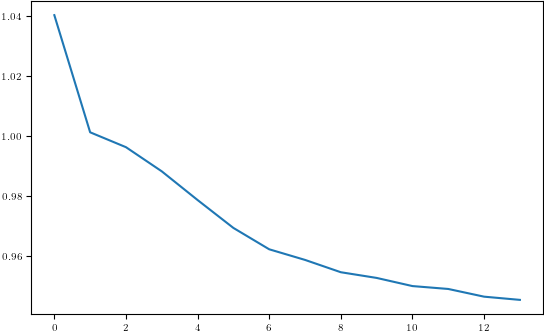

In [214]:
_ = plt.plot(train_loss_results)

In [161]:
samples = model.sample(
    num_samples=1,
    iterations=100
)

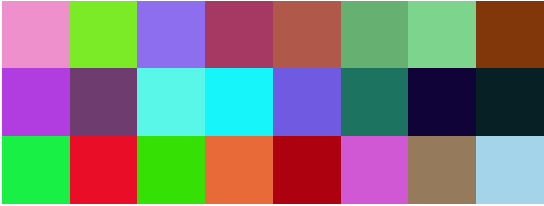

In [162]:
plt.imshow(samples[0])
_ = plt.axis('off')